In [40]:
import pandas as pd
import pymysql
import matplotlib.pyplot as plt
import numpy as np
import pyCloudy as pc
import pyneb as pn
%matplotlib inline

In [2]:
# Connect to the database
co = pymysql.connect(host='132.248.3.66', db='3MdB', 
                     user='OVN_user', passwd='oiii5007') 

In [5]:
# Compute some line ratios from the observation paper by Parker et al, 2011
RO_obs = (4.7+3.1) / 854
RS_obs = (49.+40) / 5.9
RO3_obs = 28./854
RN2_obs = 8.5/453
print(RO_obs, RS_obs, RO3_obs, RN2_obs)

(0.009133489461358314, 15.084745762711863, 0.03278688524590164, 0.018763796909492272)


In [3]:
# Look for the models that fit some lines from the 3MdB database
res = pd.read_sql("""SELECT 
N as ID,
file,
OXYGEN as O,
NITROGEN as N,
logU_mean,
Hbfrac,
atm1 as teff,
lumi,
dens,
radius,
HE_2__4686A / H__1__4861A as HeII,
TOTL__7325A/O__3__5007A as RO,
(S_II__6731A+S_II__6716A)/S__3__6312A as RS,
TOTL__4363A/O__3__5007A as RO3,
N__2__5755A/N__2__6584A as RN2,
O__3__5007A/H__1__4861A as O3,
N__2__6584A/H__1__4861A as N2
FROM tab 
WHERE ref like 'PNe_2014' 
AND abs(HE_2__4686A/H__1__4861A - 0.7) / 0.7 < 0.3
AND abs(TOTL__7325A/O__3__5007A - 0.00913) / 0.00913 < 0.3 
AND abs((S_II__6731A+S_II__6716A)/S__3__6312A - 15.1 ) / 15.1 < 0.3
AND abs(N__2__5755A/N__2__6584A - 0.0188) / 0.0188 < 0.3
AND abs(O__3__5007A/H__1__4861A - 8.54) / 8.54 < 0.3
AND abs(N__2__6584A/H__1__4861A - 4.53) / 4.53 < 0.3
AND abs(TOTL__4363A/O__3__5007A - 0.0328) / 0.0328 < 0.6
""", 
con=co)
#


In [4]:
# This is the number of results we have
len(res)

91

In [6]:
# Let's define a kind of Khi2. And print the 30 best results
def khi2(label, obs, sigma=0.2):
    return ((res[label] - obs)/obs/sigma)**2

khi2_tot =        ((khi2('HeII', 0.7) + 
                    khi2('RO', RO_obs) +
                    khi2('RS', RS_obs) +
                    khi2('RO3', RO3_obs, sigma=0.4) +
                    khi2('RN2', RN2_obs) +
                    khi2('O3', 8.54) +
                    khi2('N2', 4.53))/7)
res['khi2'] = khi2_tot
res=res.sort_values('khi2')
print(res[0:30])

         ID          file     O     N  logU_mean  Hbfrac      teff     lumi  \
88  2337479  BB_G1_903572 -3.36 -3.75   -2.48161     1.0  300000.0  4.00000   
53  1994037  BB_G1_903680 -3.36 -3.75   -2.48319     1.0  300000.0  4.00000   
69  2130315  BB_G1_903788 -3.36 -3.75   -2.48775     1.0  300000.0  4.00000   
25  1821381  BB_G1_903896 -3.36 -3.75   -2.50433     1.0  300000.0  4.00000   
89  2337512  BB_G1_903572 -3.36 -3.75   -2.48229     1.0  300000.0  4.00000   
54  1994045  BB_G1_903680 -3.36 -3.75   -2.48391     1.0  300000.0  4.00000   
70  2130319  BB_G1_903788 -3.36 -3.75   -2.48848     1.0  300000.0  4.00000   
26  1821385  BB_G1_903896 -3.36 -3.75   -2.50544     1.0  300000.0  4.00000   
36  1863948  BB_G1_904004 -3.36 -3.75   -2.55614     1.0  300000.0  4.00000   
37  1863952  BB_G1_904004 -3.36 -3.75   -2.55806     1.0  300000.0  4.00000   
28  1832057  BB_G1_897525 -3.36 -3.75   -2.35075     1.0  240000.0  4.00000   
57  2078810  BB_G1_897633 -3.36 -3.75   -2.35255    

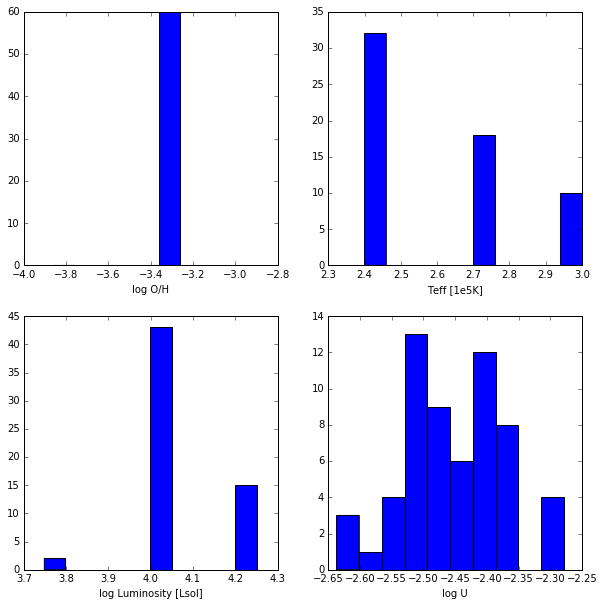

In [7]:
# Let's do some histograms of the 60 best models
res2 = res[0:60]
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,10))
ax1.hist(res2['O'])
ax1.set_xlabel('log O/H')
ax2.hist(res2['teff']/1e5)
ax2.set_xlabel('Teff [1e5K]')
ax3.hist(res2['lumi'])
ax3.set_xlabel('log Luminosity [Lsol]')
ax4.hist(res2['logU_mean'])
ax4.set_xlabel('log U');

In [8]:
# Let's choose one model and use its name and ID from 3MdB.
print(res.loc[6])
model_name=res.loc[6]['file']
model_ID = int(res.loc[6]['ID'])

ID               1791853
file         BB_C_864370
O                  -3.36
N                  -3.75
logU_mean       -2.39751
Hbfrac                 1
teff              270000
lumi             4.25042
dens             2.47712
radius                16
HeII            0.727984
RO             0.0107737
RS               16.0698
RO3            0.0153337
RN2            0.0205292
O3                10.929
N2               3.41823
khi2            0.915346
Name: 6, dtype: object


In [52]:
# All the 3MdB fields can be download using the N ID
MdB_model = pd.read_sql("SELECT * from tab where N = {}".format(model_ID), con=co)
print(MdB_model)

         N    user date_submitted date_running       ref         file  \
0  1791853  Gloria           None         None  PNe_2014  BB_C_864370   

              dir C_version geom    atm_cmd      ...       F25__2500M_rad  \
0  PNe_2014b/BB_C     10.00       Blackbody      ...             0.195966   

   F60__6000M_rad F100_1000M_rad MIPS_2400M_rad MIPS_7000M_rad  \
0        0.024701       0.010589         0.1949       0.000907   

   MIPS_1600M_rad IRAC_3600M_rad IRAC_4500M_rad IRAC_5800M_rad IRAC_8000M_rad  
0        0.001002       0.004602        0.01723       0.003929       0.082944  

[1 rows x 511 columns]


In [9]:
# Connect to 3MdB
from pyCloudy.db.use3MdB import print_input
OVN_dic = {'host' : '132.248.3.66', 
       'user_name' : 'OVN_user',
       'user_passwd' : 'oiii5007',
       'base_name' : '3MdB',
       'pending_table' : '`pending`',
       'master_table' : '`tab`',
       'teion_table' : '`teion`',
       'abion_table' : '`abion`',
       'temis_table' : '`temis`',
       'lines_table' : '`lines`',
       'seds_table': '`seds`' 
       }
# Generate the input file for Cloudy from the 3MdB record
print_input(model_ID, OVN_dic=OVN_dic, read_tab=True, dir='../models')

In [13]:
# You have to use Cloudy 13 for this run, as the program is not ready for C13... 
# And it also needs to be run with python 2, as python 3 changed the way strings are printed and I did not updated for this.
pc.config.cloudy_exe = '/usr/local/Cloudy/c13.03/source/cloudy.exe'
pc.run_cloudy(dir_ = '../models/', n_proc = 1, use_make = False, model_name = model_name)

In [14]:
# Read the cloudy model into a CloudyModel object
M = pc.CloudyModel('../models/{}'.format(model_name))

In [15]:
M.print_stats()

 Name of the model: ../models/BB_C_864370
 R_in (cut) = 1.000e+16 (1.000e+16), R_out (cut) = 2.936e+18 (2.936e+18)
 H+ mass = 1.00e+01, H mass = 2.68e+01 N zones: 406
 <H+/H> = 0.80, <He++/He> = 0.53, <He+/He> = 0.34
 <O+++/O> = 0.19, <O++/O> = 0.29, <O+/O> = 0.16
 <N+++/O> = 0.19, <N++/O> = 0.31, <N+/O> = 0.21
 T(O+++) = 14428, T(O++) = 13302, T(O+) = 11519
 <ne> = 133,  <nH> = 300, T0 = 12728, t2=0.0626
 <log U> = -2.71


In [16]:
M.emis_labels

array(['BAC___3646A', 'COUT__3646A', 'CREF__3646A', 'H__1__4861A',
       'TOTL__4861A', 'H__1__6563A', 'H__1__4340A', 'H__1__4102A',
       'H__1__3970A', 'H__1__3835A', 'H__1__1216A', 'H__1_4051M',
       'H__1_2625M', 'H__1_7458M', 'HE_1__5876A', 'CA_B__5876A',
       'HE_1__7281A', 'HE_1__7065A', 'HE_1__4471A', 'CA_B__4471A',
       'HE_1__6678A', 'CA_B__6678A', 'TOTL_1083M', 'HE_2__1640A',
       'HE_2__4686A', 'C__1__8727A', 'TOTL__9850A', 'C_IC__9850A',
       'TOTL__2326A', 'C__2__1335A', 'C__2__1761A', 'TOTL__6580A',
       'C__2__4267A', 'C__2_1576M', 'C__3_9770A', 'C__3__1907A',
       'C__3__1910A', 'C__3__4649A', 'C__3__2297A', 'TOTL__1549A',
       'C__4__1549A', 'C__4__4659A', 'N__1__5198A', 'N__1__5200A',
       'N__2__5755A', 'N_2R__5755A', 'N__2__6548A', 'N__2__6584A',
       'N__2__2141A', 'N__2__4239A', 'N__2__4041A', 'TOTL__5679A',
       'N__2_1217M', 'N__2_2054M', 'N__3_5721M', 'N__3__4641A',
       'TOTL__1750A', 'N__3__4379A', 'N__4__1485A', 'N__4__1719A',
    

In [53]:
def compare_obs(M, label, obs_value):
    print('{} {:6.1f} {:6.1f}'.format(label, obs_value,M.get_emis_vol(label)/M.get_emis_vol('H__1__4861A')*100))

In [54]:
# This will compare the model and the results
print('LINE          OBS   MODEL')
compare_obs(M, 'O_II__3726A', 333)
compare_obs(M, 'O_II__3729A', 333)
compare_obs(M, 'NE_3__3869A', 135)
compare_obs(M, 'TOTL__4363A', 28)
compare_obs(M, 'HE_2__4686A', 70)
compare_obs(M, 'O__3__5007A', 854)
compare_obs(M, 'N__2__5755A', 8.5)
compare_obs(M, 'HE_1__5876A', 11)
compare_obs(M, 'S__3__6312A', 5.9)
compare_obs(M, 'N__2__6584A', 453)
compare_obs(M, 'S_II__6716A', 49)
compare_obs(M, 'S_II__6731A', 40)
compare_obs(M, 'AR_3__7135A', 19)
compare_obs(M, 'O_II__7323A', 4.7)
compare_obs(M, 'O_II__7332A', 3.1)
O3 = pn.Atom('O',3)
N2 = pn.Atom('N',2)
T_O3_obs = O3.getTemDen(28./854, den=300., wave1=4363, wave2=5007)
T_O3_mod = O3.getTemDen(M.get_emis_vol('TOTL__4363A')/M.get_emis_vol('O__3__5007A'), den=300., wave1=4363, wave2=5007)
print('Te(OIII)    {:6.0f} {:6.0f}'.format(T_O3_obs, T_O3_mod))
T_N2_obs = N2.getTemDen(8.5/453, den=300., wave1=5755, wave2=6584)
T_N2_mod = N2.getTemDen(M.get_emis_vol('N__2__5755A')/M.get_emis_vol('N__2__6584A'), den=300., wave1=5755, wave2=6584)
print('Te(NII)     {:6.0f} {:6.0f}'.format(T_N2_obs, T_N2_mod))
print('Compare the electron temeprature in the N+ and O++ regions...')

LINE          OBS   MODEL
O_II__3726A  333.0  205.8
O_II__3729A  333.0  247.1
NE_3__3869A  135.0  163.4
TOTL__4363A   28.0   16.4
HE_2__4686A   70.0   73.0
O__3__5007A  854.0 1045.7
N__2__5755A    8.5    7.7
HE_1__5876A   11.0    6.4
S__3__6312A    5.9    6.4
N__2__6584A  453.0  379.6
S_II__6716A   49.0   61.1
S_II__6731A   40.0   51.3
AR_3__7135A   19.0   26.7
O_II__7323A    4.7    6.9
O_II__7332A    3.1    5.6
Te(OIII)     19702  13643
Te(NII)      10980  11353
Compare the electron temeprature in the N+ and O++ regions...


In [54]:
co.close()